## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)


## Read dataset

In [2]:
c_ = Dataset_load.load_config()
awo, aw, ewo, ew = c_['_colors']  

In [3]:
import yaml
import os
from pathlib import Path
path = os.getcwd()
substring = "nuisance_summary"
path = path[: path.find(substring)] + substring + "/"
c = yaml.safe_load(Path(path + "config_bkgext.yaml").read_text()) 
c['source'] = 'MSH'
awo, aw, ewo, ew = c['colors']  
c['folder'] = c['sys']+"_"+ c['source']+"_" +c['model'] 


In [4]:
print(c)

{'bias': 0, 'case': 'local', 'colors': [[[0.8901960784313725, 0.10196078431372549, 0.10980392156862745], [0.984313725490196, 0.6039215686274509, 0.6]], [[0.12156862745098039, 0.47058823529411764, 0.7058823529411765], [0.6509803921568628, 0.807843137254902, 0.8901960784313725]], [[1.0, 0.4980392156862745, 0.0], [0.9921568627450981, 0.7490196078431373, 0.43529411764705883]], [[0.41568627450980394, 0.23921568627450981, 0.6039215686274509], [0.792156862745098, 0.6980392156862745, 0.8392156862745098]]], 'corrlength': 2, 'figformat': 'pdf', 'livetime': 2.154434690031884, 'livetimes': [0.01, 0.021544346900318832, 0.046415888336127774, 0.1, 0.21544346900318834, 0.46415888336127775, 1.0, 2.154434690031884, 4.641588833612778, 10.0, 21.544346900318832, 46.41588833612777, 100.0], 'local': {'path': '/home/katrin/Documents', 'path_pksflare': '/home/katrin/Documents/nuisance_summary/PKS_flare'}, 'magnitude': 10, 'model': 'crab_cutoff', 'norm': 0.0, 'parameter_names': [['amplitude', 'index'], ['amplit

In [5]:
livetime = 100.0 # c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)
print(sys)

100.0
Bkgext


In [6]:
c['model']

'crab_cutoff'

In [7]:
%%time
amplitude= Parameter('amplitude', value = 3.85e-12, unit=u.Unit("1 / (TeV s cm2)"))
dataset_input_point  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = [amplitude],
                                           spatial_model =None)
from gammapy.modeling.models import GaussianSpatialModel
gaussian = GaussianSpatialModel(lon_0 = dataset_input_point._geom.center_skydir.ra,
                                lat_0 = dataset_input_point._geom.center_skydir.dec,
                                sigma = 0.3 *u.deg
                               )


dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = [amplitude],
                                           spatial_model =gaussian)


Position <SkyCoord (ICRS): (ra, dec) in deg
    (329.68, -30.22166667)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (329.68, -30.22166667)> is outside valid IRF map range, using nearest IRF defined within


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-MSH-simulated-100.0-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-MSH-simulated-100.0-hr.fits.gz
CPU times: user 12.7 s, sys: 410 ms, total: 13.1 s
Wall time: 13.2 s


In [8]:
dataset_input._geom

<WCSAxes: >

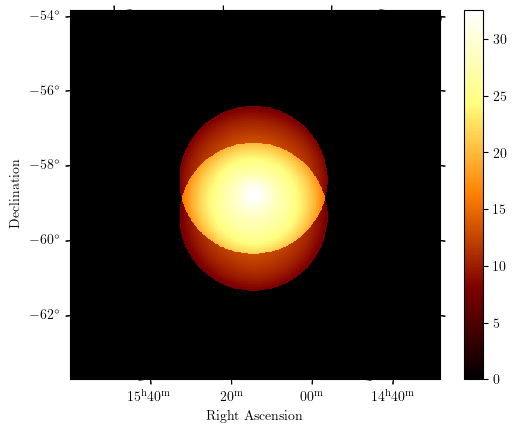

In [9]:
dataset_input.npred().sum_over_axes().plot(add_cbar =1)

setup bkg V
add_bkg_systematic_V
magnitude 10 corrlength 2


array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1       , 0.06666667, 0.03333333, 0.        ,
       0.00625   , 0.0125    , 0.01875   , 0.025     , 0.03125   ,
       0.0375    , 0.04375   , 0.05      , 0.05625   , 0.0625    ,
       0.06875   , 0.075     , 0.08125   , 0.0875    , 0.09375   ])

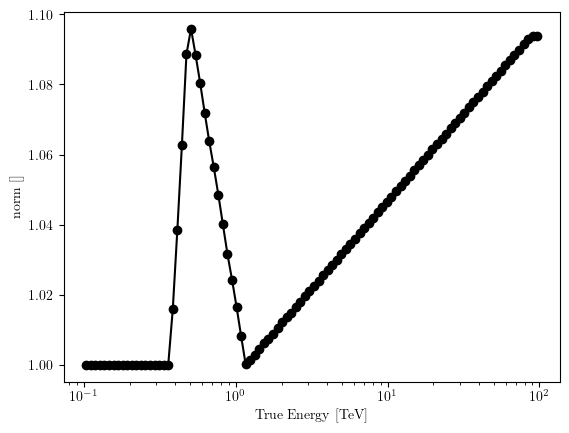

In [10]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
#setup.set_irf_model(dataset_asimov_N)
if "Bkg" in sys or "BKG" in sys:

    # piece wise model
    # remove old bkg model
    setup.set_up_bkg_sys_V( breake = 3,
                        index1 = 8,
                        index2 = 1.5, 
                        magnitude = magnitude )

    dataset_asimov, dataset_asimov_N = setup.run()

    #setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    #setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    dataset_asimov_N.background_model.parameters['norm4'].frozen = True
    print("magnitude", magnitude, "corrlength", corrlength)
    setup.set_bkg_prior(dataset_asimov_N, magnitude= magnitude, corrlength= corrlength)
    frozen_pos = 1
    if frozen_pos:
        dataset_asimov.models.parameters['lon_0'].frozen = True
        dataset_asimov.models.parameters['lat_0'].frozen = True
        dataset_asimov_N.models.parameters['lon_0'].frozen = True
        dataset_asimov_N.models.parameters['lat_0'].frozen = True
    else:
        for d in [dataset_asimov, dataset_asimov_N]:
            delta = 0.01 
            dataset_asimov.models.parameters['lon_0'].min = dataset_asimov.models.parameters['lon_0'].value - delta
            dataset_asimov.models.parameters['lon_0'].max = dataset_asimov.models.parameters['lon_0'].value + delta 
            dataset_asimov.models.parameters['lat_0'].min = dataset_asimov.models.parameters['lat_0'].value - delta
            dataset_asimov.models.parameters['lat_0'].max = dataset_asimov.models.parameters['lat_0'].value + delta
                
         
    
    
ax = setup.dataset_helper.background_model.spectral_model.plot(color= 'black', marker = 'o')

ax.set_yscale("linear")
setup.dataset_helper.background_model.spectral_model.parameters.value

In [11]:
dataset_asimov_N.background_model.evaluate(1*u.TeV)

<Quantity [1.]>

In [12]:
setup.dataset_helper.background_model.evaluate(1*u.TeV)

<Quantity [1.01786386]>

<WCSAxes: >

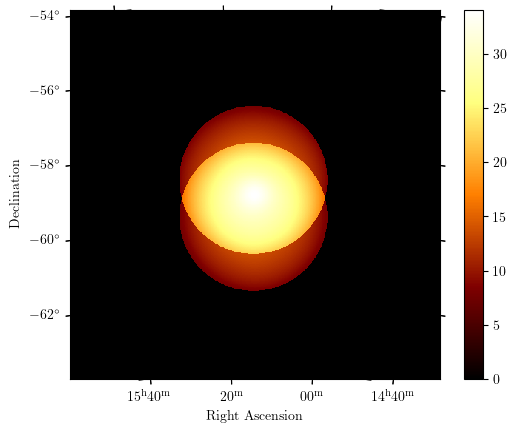

In [13]:
setup.dataset_helper.counts.sum_over_axes().plot(add_cbar = 1)

<WCSAxes: >

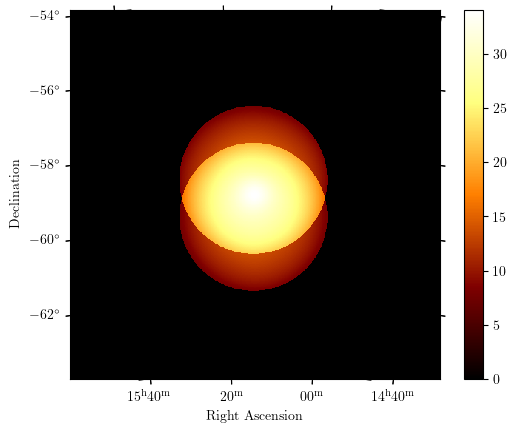

In [14]:
setup.dataset_helper.npred().sum_over_axes().plot(add_cbar = 1)

<WCSAxes: >

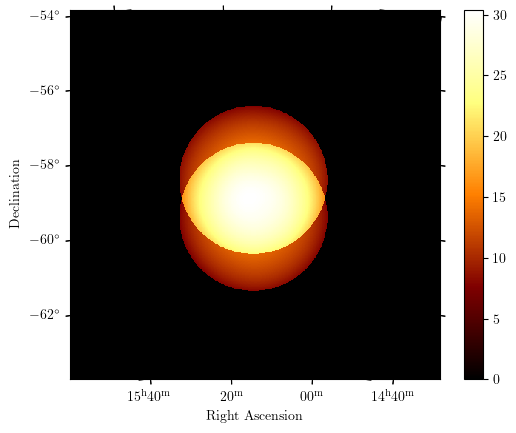

In [15]:
setup.dataset_helper.npred_background().sum_over_axes().plot(add_cbar = 1)

shift 1.0


(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

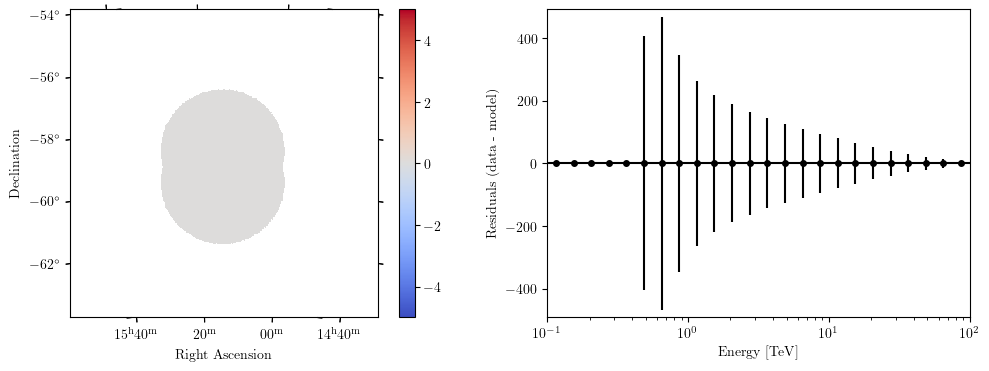

In [16]:
setup.dataset_helper.plot_residuals()

<WCSAxes: >

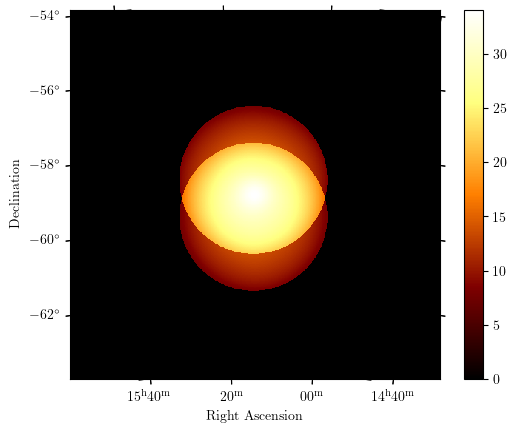

In [17]:
dataset_asimov_N.counts.sum_over_axes().plot(add_cbar = 1)

<WCSAxes: >

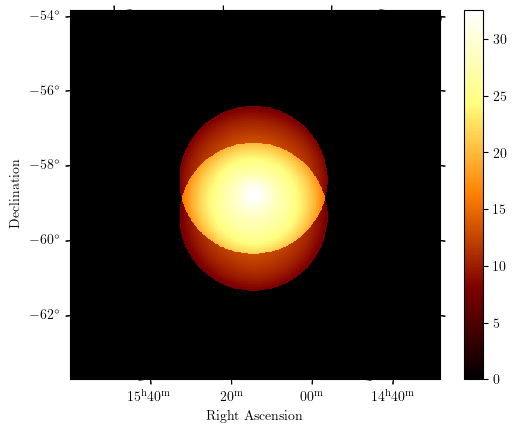

In [18]:
dataset_asimov_N.npred().sum_over_axes().plot(add_cbar = 1)

<WCSAxes: >

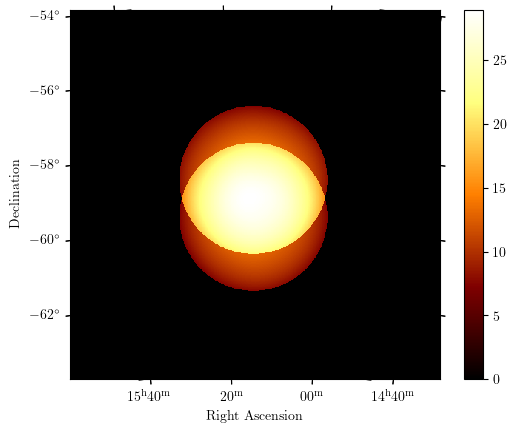

In [19]:
dataset_asimov_N.npred_background().sum_over_axes().plot(add_cbar = 1)

shift 1.0


(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

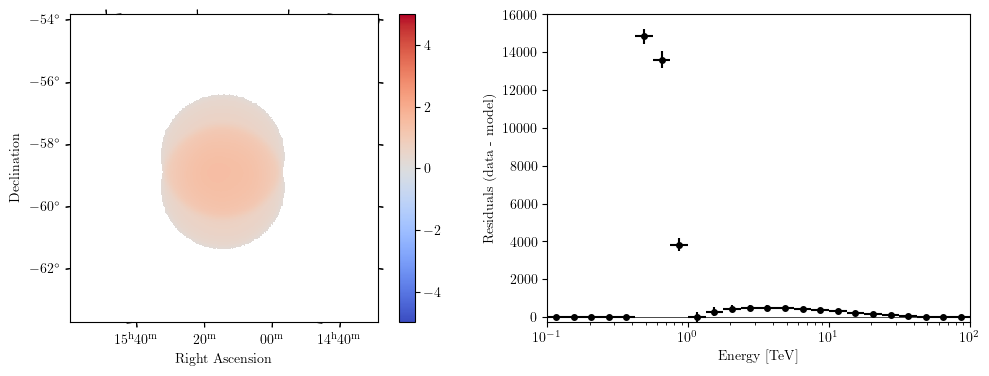

In [20]:
dataset_asimov_N.plot_residuals()


In [21]:
%%time
fitting = 0
if fitting:
    fit_cor = Fit(store_trace=0)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit_cor.backend = "minuit"
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_asimov)
    print(result_cor)
    print("saving")
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models.write(path,overwrite=True)
    
    
else:
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
    print(path[:-4])
    cov = dataset_asimov.models.read_covariance(path = path[:-4]+"_covariance.dat", filename = "",
                                            format="ascii.fixed_width")


../Bkgext_MSH_crab_cutoff/data/0_model_livetime_100.0
CPU times: user 17 ms, sys: 5.24 ms, total: 22.3 ms
Wall time: 23 ms


In [22]:
%%time
fitting = 0
if fitting:
    fit_cor = Fit(store_trace=0)
    result_cor = fit_cor.run(dataset_asimov_N)
    print(result_cor)
    print("saving")
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N.models.write(path,overwrite=True)
    
    
else:
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N.models = Models.read(path)
    dataset_asimov_N.background_model.parameters['_norm'].value = 1.

CPU times: user 126 ms, sys: 567 µs, total: 126 ms
Wall time: 191 ms


In [23]:
print(dataset_asimov_N.background_model)

FoVBackgroundModel

  Name                      : dataset_N-bkg
  Datasets names            : ['dataset_N']
  Spectral model type       : PiecewiseNormSpectralModel
  Parameters:
    _norm      (frozen)        :      1.000                  
    norm0      (frozen)[prior] :      0.000                  
    norm1      (frozen)[prior] :      0.000                  
    norm2      (frozen)[prior] :      0.000                  
    norm3      (frozen)[prior] :      0.000                  
    norm4      (frozen)[prior] :      0.000                  
    norm5              [prior] :      0.100  +/-    0.00             
    norm6              [prior] :      0.067  +/-    0.00             
    norm7              [prior] :      0.032  +/-    0.00             
    norm8              [prior] :      0.002  +/-    0.00             
    norm9              [prior] :      0.003  +/-    0.00             
    norm10             [prior] :      0.015  +/-    0.00             
    norm11             [prior

In [24]:
from scipy.linalg import inv
cov = inv(dataset_asimov_N.background_model.parameters.prior[1].covariance_matrix)
cov[-1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.08846265e-12, 1.19453059e-12, 1.37550561e-12,
       1.64873790e-12, 3.98326543e-12, 6.84097889e-11, 1.52388989e-09,
       2.69958212e-08, 3.72664598e-07, 4.00652869e-06, 3.35462619e-05,
       2.18749111e-04, 1.11089965e-03, 4.39369336e-03, 1.35335283e-02,
       3.24652467e-02, 6.06530660e-02, 8.82496903e-02, 1.00000000e-01])

(0.4, 100)

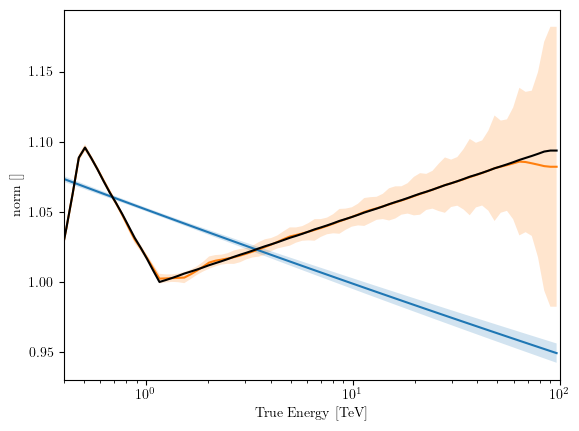

In [25]:
ax = dataset_asimov_N.background_model.spectral_model.plot(color= 'tab:orange')
ax = dataset_asimov_N.background_model.spectral_model.plot_error(facecolor= 'tab:orange')

ax = dataset_asimov.background_model.spectral_model.plot(color= 'tab:blue')
ax = dataset_asimov.background_model.spectral_model.plot_error(facecolor= 'tab:blue')

ax = setup.dataset_helper.background_model.spectral_model.plot(color= 'black')

ax.set_yscale("linear")
ax.set_xlim(0.4, 100)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000026e-12 1.00002047e-12 1.00126642e-12
 1.06101937e-12 3.28973485e-12 6.79158609e-11 1.52399797e-09
 2.69967850e-08 3.72666317e-07 4.00653074e-06 3.35462638e-05
 2.18749113e-04 1.11089965e-03 4.39369336e-03 1.35335283e-02
 3.24652467e-02 6.06530660e-02 8.82496903e-02 1.00000000e-01]


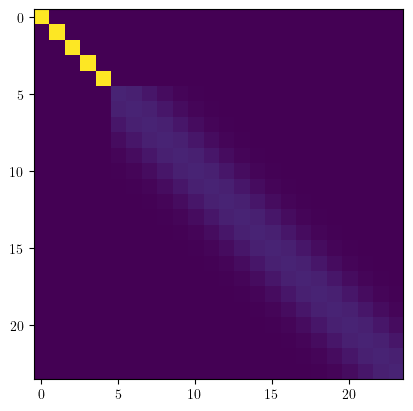

In [26]:
from Dataset_Setup import GaussianCovariance_matrix
cov = GaussianCovariance_matrix(size = len(setup.emask()),
                                        magnitude = magnitude, 
                                        corrlength = corrlength)
plt.imshow(cov.cov())
print(cov.cov()[-1])

shift 1.0
shift 1.0


(-70.0, 70.0)

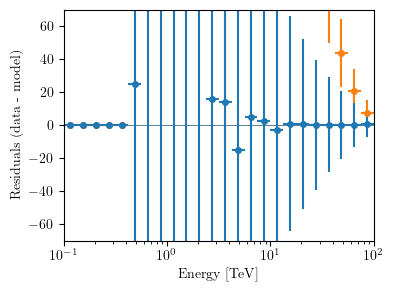

In [27]:
fig, ax = plt.subplots(1,1, figsize = (4,3))
method = 'diff'
ax = dataset_asimov.plot_residuals_spectral(color = 'tab:orange', method = method)
dataset_asimov_N.plot_residuals_spectral(ax = ax, color = 'tab:blue', method = method)
ax.set_ylim(-70,70)

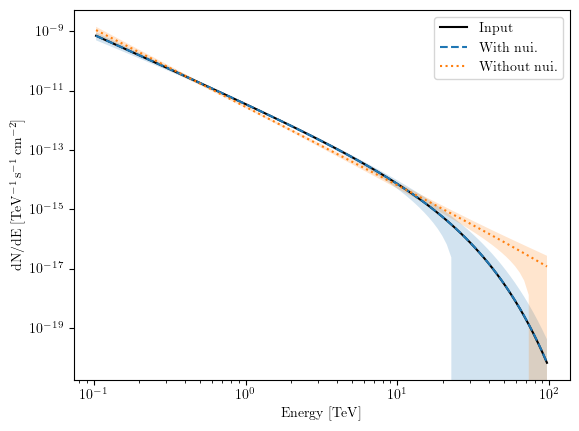

In [28]:

ax = dataset_input.models[0].spectral_model.plot(color = 'black', label = 'Input')
dataset_asimov_N.models[0].spectral_model.plot(color = 'tab:blue', linestyle = 'dashed',
                                                 label = "With nui.")
dataset_asimov_N.models[0].spectral_model.plot_error(ax = ax, facecolor = 'tab:blue')

dataset_asimov.models[0].spectral_model.plot(color = 'tab:orange', linestyle = 'dotted',
                                                 label = "Without nui.")
dataset_asimov.models[0].spectral_model.plot_error(ax = ax, facecolor = 'tab:orange')



ax.legend()

In [29]:
print(setup.dataset_helper.models[0])

SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                      :      2.300  +/-    0.00             
    amplitude                  :   3.85e-12  +/- 0.0e+00 1 / (cm2 s TeV)
    reference  (frozen)        :      1.000      TeV         
    lambda_                    :      0.100  +/-    0.00 1 / TeV     
    alpha      (frozen)        :      1.000                  
    lon_0                      :    228.526  +/-    0.00 deg         
    lat_0                      :    -59.155  +/-    0.00 deg         
    sigma                      :      0.300  +/-    0.00 deg         
    e          (frozen)        :      0.000                  
    phi        (frozen)        :      0.000      deg         




In [30]:
print(dataset_asimov_N.models[0])

SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                      :      2.301  +/-    0.14             
    amplitude                  :   3.85e-12  +/- 4.4e-13 1 / (cm2 s TeV)
    reference  (frozen)        :      1.000      TeV         
    lambda_                    :      0.100  +/-    0.06 1 / TeV     
    alpha      (frozen)        :      1.000                  
    lon_0      (frozen)        :    228.526      deg         
    lat_0      (frozen)        :    -59.155      deg         
    sigma                      :      0.300  +/-    0.02 deg         
    e          (frozen)        :      0.000                  
    phi        (frozen)        :      0.000      deg         




In [31]:
print(dataset_asimov.models[0])

SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                      :      2.626  +/-    0.12             
    amplitude                  :   2.83e-12  +/- 2.6e-13 1 / (cm2 s TeV)
    reference  (frozen)        :      1.000      TeV         
    lambda_                    :      0.004  +/-    0.02 1 / TeV     
    alpha      (frozen)        :      1.000                  
    lon_0      (frozen)        :    228.526      deg         
    lat_0      (frozen)        :    -59.155      deg         
    sigma                      :      0.273  +/-    0.02 deg         
    e          (frozen)        :      0.000                  
    phi        (frozen)        :      0.000      deg         




[1.         0.         0.         0.         0.         0.
 0.0998281  0.06706293 0.03207311 0.00245803 0.00325213 0.01469478
 0.01815254 0.02429328 0.03223467 0.03708186 0.0434535  0.05047006
 0.05602393 0.06227443 0.06882082 0.07471891 0.08131074 0.08622546
 0.08221105]


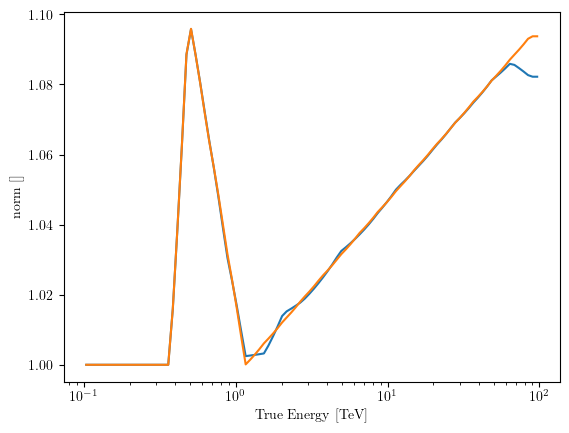

In [32]:


ax = dataset_asimov_N.background_model.spectral_model.plot()
setup.dataset_helper.background_model.spectral_model.plot()
ax.set_yscale("linear")
print(dataset_asimov_N.background_model.spectral_model.parameters.value)

In [33]:
setup.dataset_helper.background_model

In [34]:
import colors as l
#aw = l.purple
#awo =l.orange

labelw = "Fit with background systematic"
labelwo = "Fit without background systematic"

In [35]:
dataset_asimov_N.models[1].spectral_model.energy

<Quantity [ 0.1154782 ,  0.15399265,  0.2053525 ,  0.27384196,  0.36517413,
            0.48696753,  0.64938163,  0.86596432,  1.15478198,  1.53992653,
            2.05352503,  2.73841963,  3.65174127,  4.86967525,  6.49381632,
            8.65964323, 11.54781985, 15.39926526, 20.53525026, 27.38419634,
           36.51741273, 48.69675252, 64.93816316, 86.59643234] TeV>

<Axes: xlabel='Reconstructed Energy [TeV]', ylabel='Background Normalisation'>

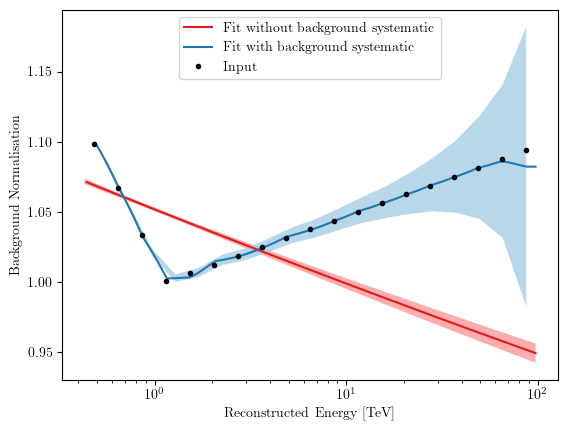

In [36]:

def plot_bkg(ax):
    dataset_asimov.models[1].spectral_model.plot((0.43, 100 ) *u.TeV, color = awo[0], label = labelwo, ax = ax)
    dataset_asimov.models[1].spectral_model.plot_error((0.42, 100 ) *u.TeV,ax = ax,
                                                      facecolor = awo[1], alpha = 0.8)
    dataset_asimov_N.models[1].spectral_model.plot((0.48, 100 ) *u.TeV,ax = ax, color = aw[0], label = labelw)
    dataset_asimov_N.models[1].spectral_model.plot_error((0.48, 100 ) *u.TeV,ax = ax,
                                                        facecolor = aw[1], alpha = 0.8, n_points = 19)
    setup.dataset_helper.models[1].spectral_model.plot((0.42, 100 ) *u.TeV,ax = ax, #linestyle = 'dashed',
                                                      color = 'black', label = "Input",  n_points = 19, marker = 'o',
                                                      linestyle = '', markersize = 3)

    ax.legend(loc = 'lower left')
    ax.legend(loc = 'upper center')
    
    ax.set_yscale("linear")
    ax.set_xlabel("Reconstructed Energy [TeV]")
    ax.set_ylabel("Background Normalisation")
    
    return ax

fig, ax = plt.subplots(1,1)
plot_bkg(ax)

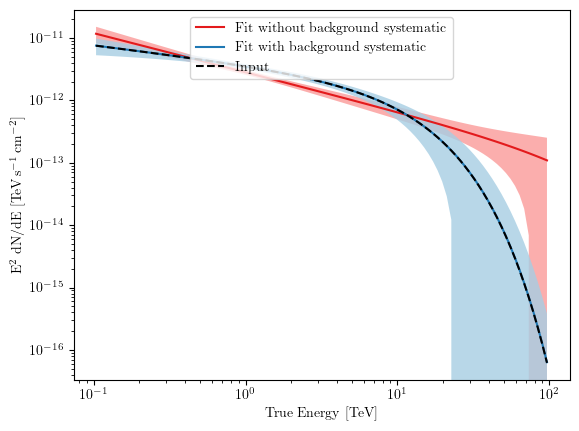

In [37]:

def plot_spec(ax):

    ep = 2
    dataset_asimov.models[0].spectral_model.plot((0.1, 100 ) *u.TeV, energy_power = ep, color = awo[0],  label = labelwo,ax = ax,)
    dataset_asimov.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                      facecolor = awo[1], alpha = 0.8, energy_power = ep)
    dataset_asimov_N.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax, energy_power = ep, color = aw[0],  label = labelw)
    dataset_asimov_N.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                        facecolor = aw[1], alpha = 0.8, 
                                                        energy_power = ep)
    setup.dataset_helper.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax, energy_power = ep, color = 'black', linestyle = 'dashed',
                                                      label = "Input")
    
    ax.legend(loc = 'lower left')
    ax.legend(loc = 'upper center')
    
    ax.set_xlabel("True Energy [TeV]")
    
    
fig, ax = plt.subplots(1,1)
plot_spec(ax)

In [38]:
dataset_asimov.mask.data.sum(axis=(2,1))

array([    0,     0,     0,     0,     0, 41797, 41797, 41797, 41797,
       41797, 41797, 41797, 41797, 41797, 41797, 41797, 41797, 41797,
       41797, 41797, 41797, 41797, 41797, 41797])

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


shift 1.0


/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


shift 1.0


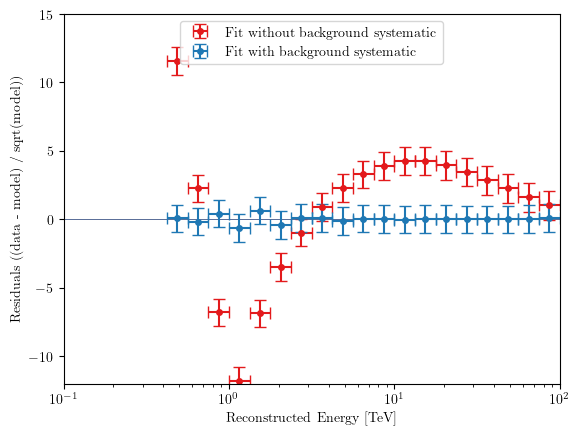

In [39]:
def plot_res(ax):

    dataset_asimov.plot_residuals_spectral(method = 'diff/sqrt(model)', color = awo[0],ax = ax, capsize = 4, label = labelwo)
    dataset_asimov_N.plot_residuals_spectral(method = 'diff/sqrt(model)', color = aw[0], ax = ax, capsize = 4, label = labelw)

    ax.set_xlabel("Reconstructed Energy [TeV]")
    ax.legend()
    ax.legend(loc = 'upper center')
    ax.set_ylim(-12,15)
    
fig, ax = plt.subplots(1,1)
plot_res(ax)



/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


shift 1.0


/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


shift 1.0


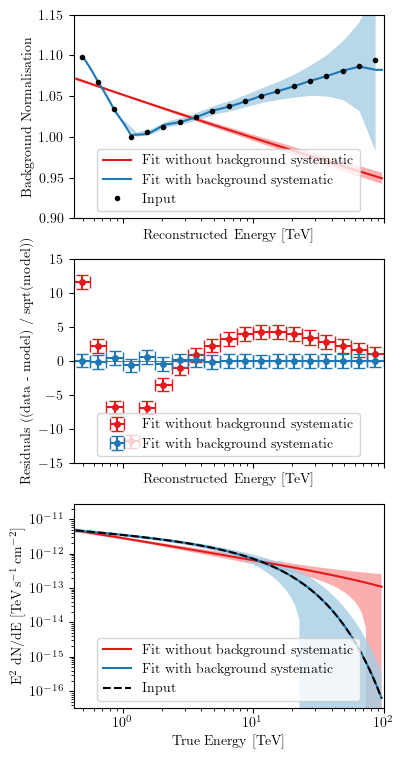

In [40]:
fig, ax = plt.subplots(3,1, figsize = (4,9), sharex = True)


plot_bkg(ax[0])
plot_spec(ax[-1])
plot_res(ax[1])

for a in ax:
    a.set_xlim(0.42, 100)
    a.legend(loc = 'lower center')
ax[0].set_ylim(0.9, 1.15)
ax[1].set_ylim(-15., 15)
    
fig.savefig(f'../{folder}/plots/bkg_{livetime}.pdf', bbox_inches = 'tight')


In [41]:
label = [ 'input', 'dataset_asimov', 'dataset_asimov_N']
for i, d in enumerate([ setup.dataset_helper, dataset_asimov, dataset_asimov_N]):
    print(label[i])

    for p in ['amplitude','index', 'lambda_','sigma']:
        par =d.models.parameters[p]
        factor = 1 
        if p == 'amplitude':
            factor = 1e12
        print(f" {p}: ${par.value*factor :.3}  \pm {par.error*factor :.3} $")
    print()

input
 amplitude: $3.85  \pm 0.0 $
 index: $2.3  \pm 0.0 $
 lambda_: $0.1  \pm 0.0 $
 sigma: $0.3  \pm 0.0 $

dataset_asimov
 amplitude: $2.83  \pm 0.258 $
 index: $2.63  \pm 0.125 $
 lambda_: $0.00404  \pm 0.0169 $
 sigma: $0.273  \pm 0.0177 $

dataset_asimov_N
 amplitude: $3.85  \pm 0.444 $
 index: $2.3  \pm 0.144 $
 lambda_: $0.0998  \pm 0.0581 $
 sigma: $0.3  \pm 0.019 $



In [42]:
models_no  = [dataset_asimov.models]
models  = [dataset_asimov_N.models]

In [43]:
headline = "\\textbf{Extended Source} &   $\Phi_0\ [10^{-12}\, \\text{cm}^{-2}\, \\text{s}^{-1}\,\\text{TeV}^{-1}]$  & $\Gamma$ & $\lambda = 1/E_c\ [\\text{TeV}^{-1}]$ & $\sigma\, [\\text{deg}]$   \\\  \hline "
input_ = '  Simulation input & $3.85 $  & $2.30 $  & $0.10 $ & 0.3  \\\  \hline'

par = models_no[0].parameters['amplitude']
without = rf' Without systematic & \errorsym {{{par.value*1e12:.3}}} {{{par.error*1e12:.3}}} '
par = models_no[0].parameters['index']
without += rf' & \errorsym {{{par.value:.3}}} {{{par.error:.3}}}   '
par = models_no[0].parameters['lambda_']
without += rf' & \errorsym  {{{par.value:.3}}} {{{par.error:.3}}}   '
par = models_no[0].parameters['sigma']
without += rf' & \errorsym  {{{par.value:.3}}} {{{par.error:.3}}}    \\  \hline'


par = models[0].parameters['amplitude']
with_ = rf' Fitting bkg. sys.   & \errorsym {{{par.value*1e12:.3}}} {{{par.error*1e12:.3}}}  '
par = models[0].parameters['index']
with_ += rf' & \errorsym  {{{par.value:.3}}} {{{par.error:.3}}}   '
par = models[0].parameters['lambda_']
with_ += rf' & \errorsym  {{{par.value:.3}}} {{{par.error:.3}}}'
par = models[0].parameters['sigma']
with_ += rf' & \errorsym  {{{par.value:.3}}} {{{par.error:.3}}}   \\  \hline'

print(headline)
print(input_)

print(without)
print(with_)

\textbf{Extended Source} &   $\Phi_0\ [10^{-12}\, \text{cm}^{-2}\, \text{s}^{-1}\,\text{TeV}^{-1}]$  & $\Gamma$ & $\lambda = 1/E_c\ [\text{TeV}^{-1}]$ & $\sigma\, [\text{deg}]$   \\  \hline 
  Simulation input & $3.85 $  & $2.30 $  & $0.10 $ & 0.3  \\  \hline
 Without systematic & \errorsym {2.83} {0.258}  & \errorsym {2.63} {0.125}    & \errorsym  {0.00404} {0.0169}    & \errorsym  {0.273} {0.0177}    \\  \hline
 Fitting bkg. sys.   & \errorsym {3.85} {0.444}   & \errorsym  {2.3} {0.144}    & \errorsym  {0.0998} {0.0581} & \errorsym  {0.3} {0.019}   \\  \hline


## Significance

In [44]:
# %%time
# dataset_asimov_ho = dataset_asimov.copy()
# models = Models(dataset_asimov.models.copy())

# models.parameters['amplitude'].value = 1e-24
# models[0].parameters.freeze_all()
# models.append(FoVBackgroundModel(dataset_name=dataset_asimov_ho.name))
# models.parameters['tilt'].frozen = False
# dataset_asimov_ho.models = models
# fitting = 0
# if fitting:
#     fit_cor = Fit(store_trace=0)
#     minuit_opts = {"tol": 0.1, "strategy": 2}
#     fit_cor.backend = "minuit"
#     fit_cor.optimize_opts = minuit_opts
#     result_cor = fit_cor.run(dataset_asimov_ho)
#     print(result_cor)
#     print("saving")
#     path = f'../{folder}/data/0_model_livetime_{livetime}_Ho.yml'
#     dataset_asimov_ho.models.write(path,overwrite=True)
    
    
# else:
#     path = f'../{folder}/data/0_model_livetime_{livetime}_Ho.yml'
#     dataset_asimov_ho.models = Models.read(path)

# print()
# print("Delta Ts: ", dataset_asimov_ho.stat_sum()- dataset_asimov.stat_sum())


In [45]:
# %%time
# dataset_asimov_ho_N = dataset_asimov_N.copy()
# models = Models(dataset_asimov_N.models.copy())

# models.parameters['amplitude'].value = 1e-24
# models[0].parameters.freeze_all()
# dataset_asimov_ho_N.models = models
# setup.set_piecewise_bkg_model(dataset_asimov_ho_N)
# setup.set_bkg_prior(dataset_asimov_ho_N, magnitude= magnitude, corrlength= corrlength)
# dataset_asimov_ho_N.models.parameters['_norm'].value = 1.
# dataset_asimov_ho_N.models.parameters['norm0'].frozen = True
# dataset_asimov_ho_N.models.parameters['norm1'].frozen = True
# dataset_asimov_ho_N.models.parameters['norm2'].frozen = True
# dataset_asimov_ho_N.models.parameters['norm3'].frozen = True

# fitting = 0
# if fitting:
#     fit_cor = Fit(store_trace=0)
#     minuit_opts = {"tol": 0.1, "strategy": 2}
#     fit_cor.backend = "minuit"
#     fit_cor.optimize_opts = minuit_opts
#     result_cor = fit_cor.run(dataset_asimov_ho_N)
#     print(result_cor)
#     print("saving")
#     path = f'../{folder}/data/0_model_livetime_{livetime}_Ho_N.yml'
#     dataset_asimov_ho_N.models.write(path,overwrite=True)
    
    
# else:
#     path = f'../{folder}/data/0_model_livetime_{livetime}_Ho_N.yml'
#     dataset_asimov_ho_N.models = Models.read(path)
#     dataset_asimov_ho_N.models.parameters['_norm'].value = 1.

# print()
# print("Delta Ts: ", dataset_asimov_ho_N.stat_sum()- dataset_asimov_N.stat_sum())


## Scan

In [46]:
parameter_names_1  = ['amplitude', 'index', 'lambda_', 'sigma']

In [47]:
def computing_scan(dataset, note):
        
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(dataset)
    print(dataset_asimov.models)
    
    results = []
    for parname1 in parameter_names_1 :
        if True: #parname1 == 'lambda_':
            print("scanning",  parname1)
            dataset.models.parameters[parname1].scan_n_values=numpoints
            result = fit_cor.stat_profile(dataset,
                                 dataset.models.parameters[parname1],
                                reoptimize = True
                                )

            contour_write = dict()
            for k in result.keys():
                print(k)
                if k != "fit_results":
                    contour_write[k] = [float(_) for _ in result[k]]#.tolist()
            print(contour_write)
            with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}_{livetime}.yml", "w") as outfile:
                yaml.dump(contour_write, outfile, default_flow_style=False)

            results.append(result)
    return results
        
def read_in_scan(note):
    results = []
    for parname1 in parameter_names_1 :
        try:
            with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}_{livetime}.yml", "r") as stream:
                contour = yaml.safe_load(stream)
        except:
            with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{livetime}.yml", "r") as stream:
                contour = yaml.safe_load(stream)
        results.append(contour)
    return results


{'Crablog.spectral.amplitude_scan': [2.3110196083393007e-12, 2.356316060695892e-12, 2.402500332692217e-12, 2.4495898257730174e-12, 2.497602282454886e-12, 2.546555793011306e-12, 2.5964688022888122e-12, 2.6473601166566583e-12, 2.699248911092743e-12, 2.7521547364084157e-12, 2.806097526614898e-12, 2.861097606434039e-12, 2.9171756989563806e-12, 2.9743529334492277e-12, 3.032650853317803e-12, 3.0920914242224345e-12, 3.152697042354853e-12, 3.214490542876648e-12, 3.2774952085232357e-12, 3.34173477837635e-12], 'stat_scan': [63019.169598085, 63018.40096717929, 63017.70049216172, 63017.07040640513, 63016.51312515453, 63016.0307878095, 63015.62571273299, 63015.30015815388, 63015.056385164666, 63014.89662001825, 63014.82309879752, 63014.838199191625, 63014.9439025233, 63015.14257341253, 63015.436286543125, 63015.82717822781, 63016.31728650307, 63016.908626017874, 63017.60313292696, 63018.4026321719]}
{'Crablog.spectral.index_scan': [2.3766044043411076, 2.402882817981684, 2.4291612316222606, 2.455439

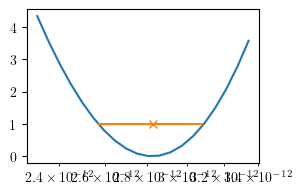

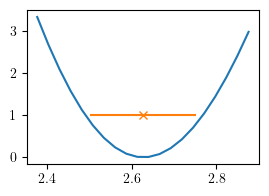

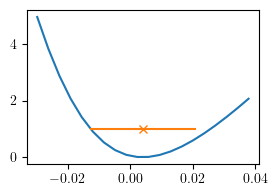

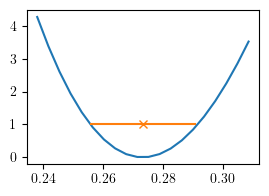

In [51]:
%%time
numpoints = 20
computing = 0
if computing:
    results = computing_scan(dataset_asimov, "2.15h")
else:
    results = read_in_scan("2.15h")
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
for i, r in enumerate(results):
    print(r)
    fig,ax = plt.subplots(1,1, figsize = (3,2))
    plt.plot(r[list(r.keys())[0]], r['stat_scan'] - np.min(r['stat_scan']))

    if i == 0 :
        ax.set_xscale('log')
    ax.errorbar(x = dataset_asimov.models.parameters[parameter_names_1[i]].value,
               y = 1,
               xerr = dataset_asimov.models.parameters[parameter_names_1[i]].error,
               fmt = 'x')

In [52]:
%%time
computing = 0
numpoints = 20

if computing:
    dataset_asimov_N.models.parameters['lon_0'].frozen = True
    dataset_asimov_N.models.parameters['lat_0'].frozen = True
    
    results_N = computing_scan(dataset_asimov_N, "N_2.15h")
else:
    results_N = read_in_scan("N_2.15h")
        
for i, r in enumerate(results):
    r_N = results_N[i]
    fig,ax = plt.subplots(1,1, figsize = (3,2))
    plt.plot(r[list(r.keys())[0]], r['stat_scan'] - np.min(r['stat_scan']))

    if i == 0 :
        ax.set_xscale('log')
    ax.errorbar(x = dataset_asimov.models.parameters[parameter_names_1[i]].value,
               y = 1,
               xerr = dataset_asimov.models.parameters[parameter_names_1[i]].error,
               fmt = 'x')
    
    plt.plot(r_N[list(r.keys())[0]], r_N['stat_scan'] - np.min(r_N['stat_scan']))

    if i == 0 :
        ax.set_xscale('log')
    ax.errorbar(x = dataset_asimov_N.models.parameters[parameter_names_1[i]].value,
               y = 1,
               xerr = dataset_asimov_N.models.parameters[parameter_names_1[i]].error,
               fmt = 'x')

FileNotFoundError: [Errno 2] No such file or directory: '../Bkgext_MSH_crab_cutoff/data/4_scan_N_2.15h_amplitude_100.0.yml'

In [53]:
import upper_limit_18_02
import colors as s
colors_ = [s.blue, s.orange,
          s.lblue, s.lorange]

#colors_ = [awo[0] , aw[0],
#           awo[1] , aw[1]]

for i, p in enumerate(parameter_names_1):
    #if p == 'index':
    if True:
        stat_profile_N = results_N[i]
        stat_profile = results[i]

        stat_profile_N['stat_scan'] -= np.min(stat_profile_N['stat_scan'])
        stat_profile['stat_scan'] -= np.min(stat_profile['stat_scan'])

        fig = plt.figure()
        ll_N_a = stat_profile_N.copy()
        case = 'spectral'
        if p == 'sigma':
            case = 'spatial'
            
        amplitude_err = dataset_asimov.models[0].parameters[p].error
        amplitude = dataset_asimov.models[0].parameters[p].value
        amplitude_err_N = dataset_asimov_N.models[0].parameters[p].error
        amplitude_N = dataset_asimov_N.models[0].parameters[p].value

        fig, ax = plt.subplots(1,1)
            
        ### LIKELIHOOD
        # scan
        ll_a = stat_profile.copy()
        ul_a = upper_limit_18_02.upper_limit(ll_a,0,0,  name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_a, x_a = ul_a.interpolate()
        plt.plot(x_a, L_a(x_a),label = "-2log (L)", linestyle = 'dashed', color = colors_[0])
    
        ylim= ax.get_ylim()
        ymax = 2#ylim[1]
        min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
        min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
        dataset_asimov.models.parameters[p].error_n = er_neg
        dataset_asimov.models.parameters[p].error_p = er_pos
        
        factor = 1
        if p == 'amplitude':
            factor = 1e11

        ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ymax, alpha = 0.5, color=colors_[2],
                        label = f'1$\sigma$ error (Scan): -{er_neg*factor:.2} +{er_pos*factor:.2} ')
     
        
        ax.vlines(amplitude-amplitude_err, ylim[0], ymax, color = colors_[0], linestyle ='dotted')
        ax.vlines(amplitude+amplitude_err, ylim[0], ymax, color = colors_[0], linestyle ='dotted',
                 label =  f'1$\sigma$ error (Minuit): {amplitude_err*factor:.2}')

           
        ### POSTERIOR
        # scan
        ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0, 
                                               name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_N_a, x_N_a = ul_N_a.interpolate()
        plt.plot(x_N_a, L_N_a(x_N_a),label = "-2log (P)", color = colors_[1])
        
        
        min_N, er_negN, er_posN = ul_N_a.likelihood_error_asymmetric()
        min_N = min_N[0]; er_negN = er_negN[0]; er_posN = er_posN[0]; 
        dataset_asimov_N.models.parameters[p].error_n = er_negN
        dataset_asimov_N.models.parameters[p].error_p = er_posN


        ax.fill_between(  [min_N-er_negN, min_N+ er_posN], ylim[0], ymax, alpha = 0.5, color = colors_[3],
                        label = f'1$\sigma$ error (Scan): -{er_negN*factor:.5} +{er_posN*factor:.5} ')
        ax.vlines(amplitude_N-amplitude_err_N, ylim[0], ymax,color = colors_[1] ,
                  linestyles='dotted'
                 )
        ax.vlines(amplitude_N+amplitude_err_N, ylim[0], ymax,color = colors_[1],
                  linestyles='dotted',
                    label = f'1$\sigma$ error (Minuit): $\pm${amplitude_err_N*factor:.5}')
        ax.vlines(setup.dataset_helper.models.parameters[p].value, ylim[0], ymax,color = 'black',
                  linestyles='dotted')
        nn = 2
        #ax.set_xlim(amplitude_N-amplitude_err_N*nn, 
        #           amplitude_N+amplitude_err_N*nn)
        ax.set_ylim(np.min(stat_profile['stat_scan'])-0.5,
                    np.min(stat_profile['stat_scan'])+ 3)

        
        
       
    
    
        xx = ax.get_xlim()
        alpha = 0.6
        ax.hlines(0, xx[0], xx[1], color = 'grey', alpha = alpha)
        ax.hlines(1, xx[0], xx[1], color = 'grey', alpha = alpha)
        if p == 'amplitude':
            str_= "[$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]"
            plt.xlabel(f"Source strength " + str_) 
        else:
            plt.xlabel(p)
        plt.ylabel("-2log (L) [arb. unit]")
        plt.legend(ncol = 2)

    fig.savefig(f"../{c['folder']}/plots/4_scan_{p}.pdf")
    
    

NameError: name 'results_N' is not defined

In [54]:
models_no  = [dataset_asimov.models]
models  = [dataset_asimov_N.models]

In [55]:
headline = "\\textbf{Extended Source} &   $\Phi_0\ [10^{-12}\, \\text{cm}^{-2}\, \\text{s}^{-1}\,\\text{TeV}^{-1}]$  & $\Gamma$ & $\lambda = 1/E_c\ [\\text{TeV}^{-1}]$ & $\sigma\, [\\text{deg}]$   \\\  \hline "
input_ = '  Simulation input & $3.85 $  & $2.30 $  & $0.10 $ & 0.3  \\\  \hline'


par = models_no[0].parameters['amplitude']
without = rf' Without systematic & \error {{{par.value*1e12:.3}}} {{{par.error*1e12:.3}}}  {{{par.error_p*1e12:.3}}}  {{{par.error_n*1e12:.3}}} '
par = models_no[0].parameters['index']
without += rf' & \error {{{par.value:.3}}} {{{par.error:.3}}}  {{{par.error_p:.3}}}  {{{par.error_n:.3}}} '
par = models_no[0].parameters['lambda_']
without += rf' & \error  {{{par.value:.3}}} {{{par.error:.3}}}  {{{par.error_p:.3}}}  {{{par.error_n:.3}}}   '
par = models_no[0].parameters['sigma']
without += rf' & \error  {{{par.value:.3}}} {{{par.error:.3}}}  {{{par.error_p:.3}}}  {{{par.error_n:.3}}}  \\  \hline'


par = models[0].parameters['amplitude']
eff = rf' Fitting bkg. sys.    & \error {{{par.value*1e12:.3}}} {{{par.error*1e12:.3}}}  {{{par.error_p*1e12:.3}}}  {{{par.error_n*1e12:.3}}} '
par = models[0].parameters['index']
eff += rf' & \error  {{{par.value:.3}}} {{{par.error:.3}}}  {{{par.error_p:.3}}}  {{{par.error_n:.3}}} '
par = models[0].parameters['lambda_']
eff += rf' & \error  {{{par.value:.3}}} {{{par.error:.3}}}  {{{par.error_p:.3}}}  {{{par.error_n:.3}}}  '
par = models[0].parameters['sigma']
eff += rf' & \error  {{{par.value:.3}}} {{{par.error:.3}}}  {{{par.error_p:.3}}}  {{{par.error_n:.3}}}  \\  \hline'

print(headline)
print(input_)
print(without)
print(eff)


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

## Fluxpoints

In [56]:
    
setup_rnd = Setup(dataset_input=dataset_input)
    # remove old bkg model
setup_rnd.set_up_bkg_sys_V( breake = 3,
                        index1 = 8,
                        index2 = 1.5, 
                        magnitude = magnitude )
dataset_rnd, dataset_rnd_N = setup_rnd.run()

dataset_rnd_N.background_model.parameters['norm0'].frozen = True
dataset_rnd_N.background_model.parameters['norm1'].frozen = True
dataset_rnd_N.background_model.parameters['norm2'].frozen = True
dataset_rnd_N.background_model.parameters['norm3'].frozen = True
setup_rnd.set_bkg_prior(dataset_rnd_N, magnitude= magnitude, corrlength= corrlength)
frozen_pos = 1
if frozen_pos:
    dataset_rnd.models.parameters['lon_0'].frozen = True
    dataset_rnd.models.parameters['lat_0'].frozen = True
    dataset_rnd_N.models.parameters['lon_0'].frozen = True
    dataset_rnd_N.models.parameters['lat_0'].frozen = True
    
rnd = 46
np.random.seed(rnd)
counts_data = np.random.poisson(setup_rnd.dataset_helper.npred().data)
dataset_rnd.counts.data = counts_data
dataset_rnd_N.counts.data = counts_data

setup bkg V
add_bkg_systematic_V


shift 1.0


(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

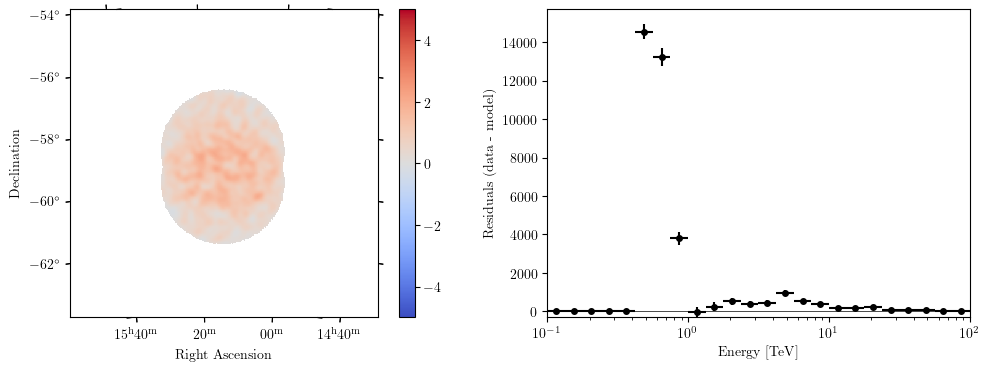

In [57]:
dataset_rnd.plot_residuals()

In [58]:
%%time
fitting =1
if fitting:
    
    fit_rnd = Fit()
    fit_rnd.run(dataset_rnd_N)
    
    fit_rnd.run(dataset_rnd)

CPU times: user 4min 55s, sys: 1min 53s, total: 6min 49s
Wall time: 6min 50s


In [59]:
from gammapy.estimators import FluxPoints

In [60]:
dataset_rnd.geoms['geom'].axes[0].edges

<Quantity [1.00000000e-01, 1.33352143e-01, 1.77827941e-01, 2.37137371e-01,
           3.16227766e-01, 4.21696503e-01, 5.62341325e-01, 7.49894209e-01,
           1.00000000e+00, 1.33352143e+00, 1.77827941e+00, 2.37137371e+00,
           3.16227766e+00, 4.21696503e+00, 5.62341325e+00, 7.49894209e+00,
           1.00000000e+01, 1.33352143e+01, 1.77827941e+01, 2.37137371e+01,
           3.16227766e+01, 4.21696503e+01, 5.62341325e+01, 7.49894209e+01,
           1.00000000e+02] TeV>

In [ ]:
%%time
computing = 1
note = 'fine'
note = ''

if computing:
    if note == 'fine':
        energy_edges = dataset_rnd.geoms['geom'].axes[0].edges#[::2]
    else:
        energy_edges = dataset_rnd.geoms['geom'].axes[0].edges[::2][2:]
        energy_edges[0] = dataset_rnd.geoms['geom'].axes[0].edges[5]
        
    esti  = FluxPointsEstimator(energy_edges= energy_edges,#,
                                selection_optional =  [ "ul"],
                                norm_min=0.2,
                            norm_max=200,
                            norm_n_values=15,
                               )
    fluxpoints = esti.run([dataset_rnd])
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fluxpoints.plot()

    # freeze all but IRF for fp and reopt = True
    dataset_rnd_N.models[0].parameters.freeze_all()
    dataset_rnd_N.models[0].parameters['amplitude'].frozen = False
    #dataset_rnd_N.background_model.parameters.freeze_all()
    esti_  = FluxPointsEstimator(energy_edges= energy_edges,
                                 selection_optional =[ "ul"],# "errn-errp", "all",
                                norm_min=0.2,
                            norm_max=2000,
                            norm_n_values=15,
                               reoptimize=True)
    fluxpoints_N = esti_.run([dataset_rnd])
    fluxpoints_N.plot(ax = ax)
    
    fluxpoints_N.write(f'../{folder}/data/fluxpoints/1P_fluxpoints_N_{rnd}{note}.fits',
                      overwrite = True)
    dataset_rnd_N.models.write(f'../{folder}/data/fluxpoints/1P_model_N_{rnd}{note}.yaml',
                          overwrite = True)
    fluxpoints.write(f'../{folder}/data/fluxpoints/1P_fluxpoints_{rnd}{note}.fits',
                    overwrite = True)
    dataset_rnd.models.write(f'../{folder}/data/fluxpoints/1P_model_{rnd}{note}.yaml',
                        overwrite = True)
else:
    fluxpoints_N = FluxPoints.read(f'../{folder}/data/fluxpoints/1P_fluxpoints_N_{rnd}{note}.fits',)
    dataset_rnd_N.models = Models.read(f'../{folder}/data/fluxpoints/1P_model_N_{rnd}{note}.yaml',)
    fluxpoints = FluxPoints.read(f'../{folder}/data/fluxpoints/1P_fluxpoints_{rnd}{note}.fits',)
    dataset_rnd.models = Models.read(f'../{folder}/data/fluxpoints/1P_model_{rnd}{note}.yaml',)
    
    
    note = ''
    fluxpoints_N_two = FluxPoints.read(f'../{folder}/data/fluxpoints/1P_fluxpoints_N_{rnd}{note}.fits',)
    dataset_rnd_N.models = Models.read(f'../{folder}/data/fluxpoints/1P_model_N_{rnd}{note}.yaml',)
    fluxpoints_two = FluxPoints.read(f'../{folder}/data/fluxpoints/1P_fluxpoints_{rnd}{note}.fits',)
    dataset_rnd.models = Models.read(f'../{folder}/data/fluxpoints/1P_model_{rnd}{note}.yaml',)
    
    

In [ ]:
fig, ax= plt.subplots()
ep = 2
dataset_asimov.models[0].spectral_model.plot((0.1, 100 ) *u.TeV, energy_power = ep, color = awo[0],  label = labelwo,ax = ax,)
dataset_asimov.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                  facecolor = awo[1], alpha = 0.8, energy_power = ep)
dataset_asimov_N.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax, energy_power = ep, color =aw[0],  label = labelw)
dataset_asimov_N.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                    facecolor = aw[0], alpha = 0.8, 
                                                    energy_power = ep)


dataset_rnd.models[0].spectral_model.plot((0.1, 100 ) *u.TeV, energy_power = ep, color = 'purple',  label = labelwo,ax = ax,
                                         linestyle = 'dotted')
dataset_rnd.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                  facecolor = 'purple', alpha = 0.3, energy_power = ep)
dataset_rnd_N.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax, energy_power = ep, color = 'darkblue',  label = labelw,
                                           linestyle = 'dotted')
dataset_rnd_N.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                    facecolor ='darkblue', alpha = 0.3, 
                                                    energy_power = ep)


setup.dataset_helper.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax, energy_power = ep, color = 'black', linestyle = 'dashed',
                                                  label = "Input")


fluxpoints.plot(ax = ax, energy_power = ep, color = 'tab:red', capsize = 4)
fluxpoints_N.plot(ax = ax, energy_power = ep, color = 'tab:blue', capsize = 4)

ax.set_xlabel("True Energy [TeV]")

    
ax.set_ylim(1e-13, 2e-11)

In [ ]:

def plot_spec(ax):

    ep = 2
    dataset_asimov.models[0].spectral_model.plot((0.1, 100 ) *u.TeV, energy_power = ep, color = awo[0],  label = '',ax = ax,)
    dataset_asimov.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                      facecolor = awo[1], alpha = 0.8, energy_power = ep)
    dataset_asimov_N.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax, energy_power = ep, color = aw[0],  label = '')
    dataset_asimov_N.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                        facecolor = aw[1], alpha = 0.8, 
                                                        energy_power = ep)
    setup.dataset_helper.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax, energy_power = ep, color = 'black', linestyle = 'dashed',
                                                      label = "Input")
    
    ax.legend(loc = 'lower left')
    ax.legend(loc = 'upper center')
    
    ax.set_xlabel("True Energy [TeV]")
    
    


In [ ]:
fig, ax = plt.subplots(3,1, figsize = (4,9), sharex = True)


plot_bkg(ax[0])
plot_spec(ax[-1])
plot_res(ax[1])


    
fluxpoints.plot(ax = ax[2], energy_power = ep, color = 'tab:orange', capsize = 2.5,
               label = "Fluxpoints w/o nuisance par.")
fluxpoints_N.plot(ax = ax[2], energy_power = ep, color = 'tab:purple', capsize = 2.5,
                 label = "Fluxpoints with nuisance par.")

for a in ax:
    a.set_xlim(0.42, 100)
    a.legend(loc = 'lower center')
ax[0].set_ylim(0.9, 1.15)
ax[1].set_ylim(-10., 7)
ax[2].set_ylim(0.1e-13, 2e-11)

fig.savefig(f'../{folder}/plots/bkg_{livetime}_fp_two.pdf', bbox_inches = 'tight')
